# Insights from Failed Orders

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [45]:
# Load datasets
data_orders = pd.read_csv("data_orders.csv")
data_offers = pd.read_csv("data_offers.csv")

In [46]:
data_orders["order_datetime"] = pd.to_datetime(data_orders["order_datetime"])

In [48]:
data_orders["order_hour"] = data_orders["order_datetime"].dt.hour

In [50]:
data_orders

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,order_hour
0,2025-04-01 18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,18
1,2025-04-01 20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,20
2,2025-04-01 12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,12
3,2025-04-01 13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,13
4,2025-04-01 21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN,21
...,...,...,...,...,...,...,...,...,...
10711,2025-04-01 13:11:35,-0.975372,51.457846,NaN,3000599186906,4,0,36.0,13
10712,2025-04-01 13:13:55,-0.975372,51.457846,NaN,3000599186962,4,0,4.0,13
10713,2025-04-01 13:17:21,-0.972926,51.457693,60.0,3000599187034,4,1,34.0,13
10714,2025-04-01 13:16:28,-0.975372,51.457846,NaN,3000599187024,4,0,6.0,13


In [57]:
failed_orders = data_orders[data_orders["order_status_key"].isin([4,9])]
failed_orders["failure_reason"] = failed_orders["order_status_key"].map({4: "Cancelled by Client", 9: "Cancelled by System"})

### Categorize by driver assignment

In [66]:
failed_orders["driver_assigned"] = failed_orders["is_driver_assigned_key"].map({0: "Before Driver Assigned", 1: "After Driver Assigned"})

/var/folders/k5/z96kr84j4y561699j28rw1_c0000gn/T/ipykernel_70393/1001340249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed_orders["driver_assigned"] = failed_orders["is_driver_assigned_key"].map({0: "Before Driver Assigned", 1: "After Driver Assigned"})


### Group by failure reason and driver assignment


In [68]:
failure_distribution = failed_orders.groupby(["failure_reason", "driver_assigned"]).size().reset_index(name="count")
failure_distribution

,failure_reason,driver_assigned,count
0,Cancelled by Client,After Driver Assigned,2744
1,Cancelled by Client,Before Driver Assigned,4489


### Plot the distribution

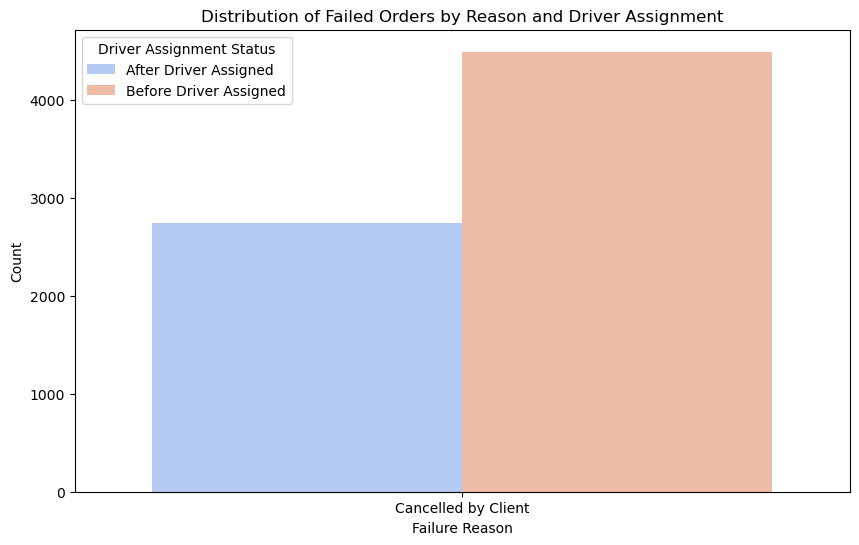

In [70]:
plt.figure(figsize=(10, 6))
sns.barplot(data=failure_distribution, x="failure_reason", y="count", hue="driver_assigned", palette="coolwarm")
plt.title("Distribution of Failed Orders by Reason and Driver Assignment")
plt.xlabel("Failure Reason")
plt.ylabel("Count")
plt.legend(title="Driver Assignment Status")
plt.show()


### Identify the category with the highest failed orders

In [71]:
highest_category = failure_distribution.loc[failure_distribution["count"].idxmax()]
print(f"Category with the highest failed orders: {highest_category['failure_reason']} ({highest_category['driver_assigned']}) with {highest_category['count']} orders.")


Category with the highest failed orders: Cancelled by Client (Before Driver Assigned) with 4489 orders.


### Failed orders by hour

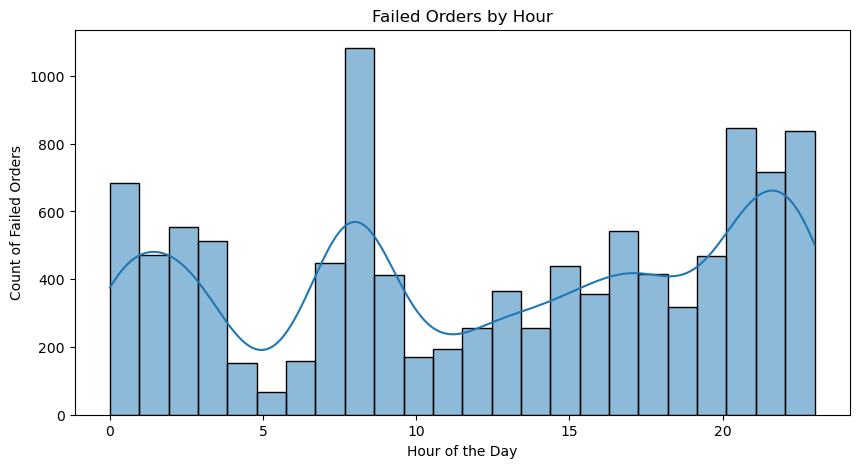

In [62]:
plt.figure(figsize=(10, 5))
sns.histplot(data=failed_orders, x="order_hour", bins=24, kde=True)
plt.title("Failed Orders by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Count of Failed Orders")
plt.show()

### Average cancellation time by hour

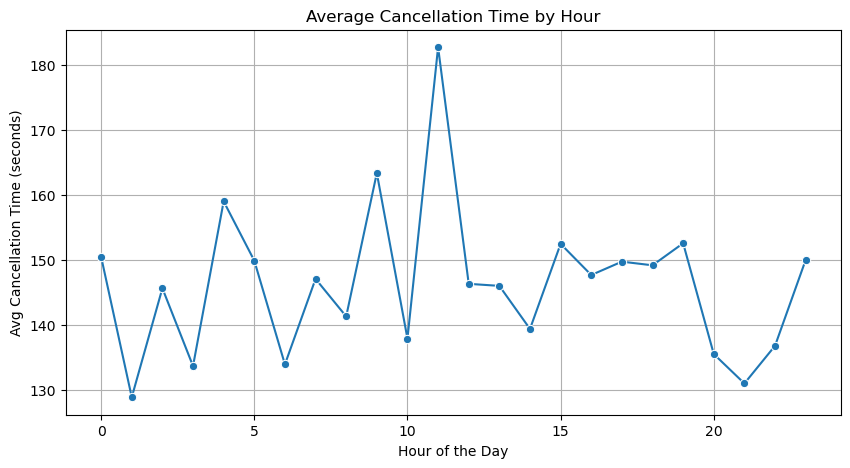

In [64]:
failed_orders = failed_orders[failed_orders["cancellations_time_in_seconds"] < failed_orders["cancellation_time_in_seconds"].quantile(0.99)]
avg_cancel_time = failed_orders.groupby("order_hour")["cancellations_time_in_seconds"].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=avg_cancel_time.index, y=avg_cancel_time.values, marker="o")
plt.title("Average Cancellation Time by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Avg Cancellation Time (seconds)")
plt.grid()
plt.show()

### Distribution of ETA by hour


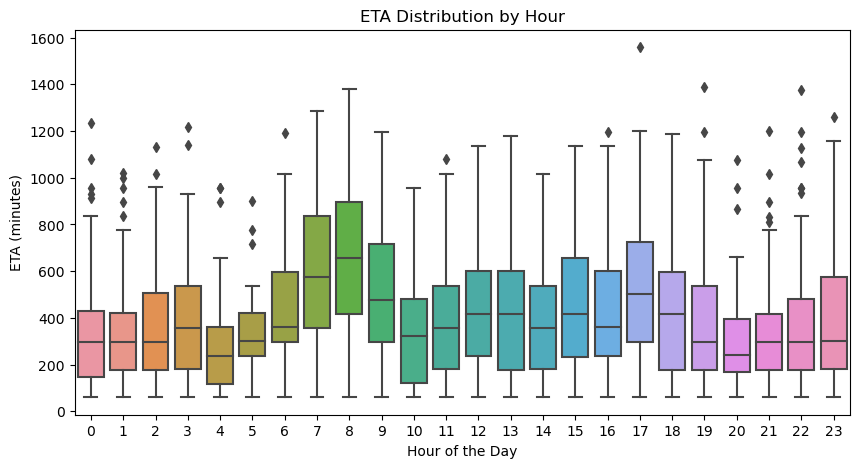

In [65]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=failed_orders, x="order_hour", y="m_order_eta")
plt.title("ETA Distribution by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("ETA (minutes)")
plt.show()

In [72]:
import folium
import h3
from folium.plugins import HeatMap

### Hexagonal clustering (Geospatial Analysis)

In [76]:
def get_hex_id(lat, lon, resolution=8):
    return h3.latlng_to_cell(lat, lon, resolution)

failed_orders["hex_id"] = failed_orders.apply(lambda row: get_hex_id(row["origin_latitude"], row["origin_longitude"]), axis=1)
hex_counts = failed_orders["hex_id"].value_counts()


/var/folders/k5/z96kr84j4y561699j28rw1_c0000gn/T/ipykernel_70393/1894931043.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed_orders["hex_id"] = failed_orders.apply(lambda row: get_hex_id(row["origin_latitude"], row["origin_longitude"]), axis=1)


In [77]:
# Get 80% of failed orders in top hexes
cutoff = hex_counts.cumsum() / hex_counts.sum()
selected_hexes = hex_counts[cutoff <= 0.8]


### Visualizing failed orders on map

In [78]:
m = folium.Map(location=[failed_orders["origin_latitude"].mean(), failed_orders["origin_longitude"].mean()], zoom_start=12)
for hex_id, count in selected_hexes.items():
    lat, lon = h3.cell_to_latlng(hex_id)
    folium.CircleMarker([lat, lon], radius=count / 50, color='red', fill=True, fill_color='red').add_to(m)
m.save("failed_orders_map.html")

print("Analysis complete. Open 'failed_orders_map.html' to view the geospatial analysis.")


Analysis complete. Open 'failed_orders_map.html' to view the geospatial analysis.


In [79]:
from IPython.display import IFrame

In [80]:
IFrame("failed_orders_map.html", width=800, height=500)